In [8]:
# --- Bibliotecas ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Configurações de plotagem
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


In [11]:
file_name = 'Dados.csv' 

try:
    # Usamos encoding='utf-8-sig' para lidar com o BOM (Byte Order Mark).
    df_raw = pd.read_csv(file_name, sep=';', on_bad_lines='skip', encoding='utf-8-sig')
except FileNotFoundError:
    print(f"Erro: Arquivo '{file_name}' não encontrado. Por favor, verifique o caminho do arquivo.")
    # Se estiver em um notebook, não use exit(), apenas pare a execução da célula.
    # exit() 

# --- Limpeza e Transformação ---
print("Colunas encontradas no arquivo:", df_raw.columns.tolist())

# Remover linhas onde colunas essenciais são nulas.
df_raw.dropna(subset=['Open Date', 'Symbol', 'Gain'], inplace=True)

# Renomear 'Gain' para 'Profit' para consistência com o resto do script
df_raw.rename(columns={'Gain': 'Profit'}, inplace=True)

# Converter 'Open Date' para datetime.
# Usamos format='mixed' para que o Pandas infira o formato para cada data individualmente.
# Isso resolve o problema de formatos de data inconsistentes no arquivo.
df_raw['Open Date'] = pd.to_datetime(df_raw['Open Date'], format='mixed', dayfirst=False)

# Converter 'Profit' para tipo numérico
df_raw['Profit'] = pd.to_numeric(df_raw['Profit'], errors='coerce')

# Selecionar colunas de interesse e ordenar pela data
df = df_raw[['Open Date', 'Symbol', 'Profit']].copy()
df.set_index('Open Date', inplace=True)
df.sort_index(inplace=True)
df.dropna(inplace=True)

print("\nDados brutos carregados e limpos:")
print(df.head())
print("\nPares de moedas encontrados:", df['Symbol'].unique())


# --- Construir Curvas de Capital e Calcular Retornos ---
# (O resto do código a partir daqui permanece o mesmo)
daily_returns = pd.DataFrame()

for symbol in df['Symbol'].unique():
    symbol_df = df[df['Symbol'] == symbol].copy()
    symbol_df['Capital_Curve'] = symbol_df['Profit'].cumsum()
    capital_daily = symbol_df['Capital_Curve'].resample('D').last().ffill()
    returns = (capital_daily + 10000).pct_change(1)
    daily_returns[symbol] = returns

daily_returns = daily_returns.iloc[1:].fillna(0)

print("\nAmostra dos retornos diários calculados para cada par:")
print(daily_returns.head())

Colunas encontradas no arquivo: ['Open Date', 'Close Date', 'Symbol', 'Action', 'Units/Lots', 'SL', 'TP', 'Open Price', 'Close Price', 'Pips', 'Gain', 'Duration (DD:HH:MM:SS)', 'Profitable(%)', 'Profitable(time duration)', 'Drawdown', 'Risk:Reward', 'Max(pips)', 'Max(EUR)', 'Min(pips)', 'Min(EUR)', 'Entry Accuracy(%)', 'Exit Accuracy(%)', 'ProfitMissed(pips)', 'ProfitMissed(EUR)']

Dados brutos carregados e limpos:
                     Symbol  Profit
Open Date                          
2011-05-10 14:45:00  USDJPY      32
2011-05-10 23:15:00  USDCHF     -24
2011-05-11 05:15:00  USDCHF       9
2011-05-11 17:00:00  GBPUSD   -1359
2011-05-12 01:15:00  USDCHF      -5

Pares de moedas encontrados: ['USDJPY' 'USDCHF' 'GBPUSD' 'EURUSD' 'AUDUSD' 'NZDUSD']

Amostra dos retornos diários calculados para cada par:
              USDJPY    USDCHF    GBPUSD  EURUSD  AUDUSD  NZDUSD
Open Date                                                       
2011-05-11  0.000000  0.000902  0.000000     0.0     0.0 

In [12]:
# Vamos usar retornos logarítmicos para a análise
log_ret = np.log(1 + daily_returns)

# --- Funções de Apoio para Otimização (do seu script) ---

def get_ret_vol_sr(weights):
    """
    Recebe os pesos e retorna um array com [retorno, volatilidade, sharpe_ratio].
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252 # Retorno anualizado
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights))) # Volatilidade anualizada
    sr = ret / vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # Retorna o negativo do Sharpe Ratio para que a função de minimização o maximize
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    # Garante que a soma dos pesos é 1
    return np.sum(weights) - 1


 ### 2a. Simulação de Monte Carlo

In [13]:
num_ports = 15000
num_assets = len(daily_returns.columns)

all_weights = np.zeros((num_ports, num_assets))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for i in range(num_ports):
    # Pesos aleatórios
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # Salvar pesos
    all_weights[i,:] = weights
    
    # Calcular métricas e salvar
    portfolio_metrics = get_ret_vol_sr(weights)
    ret_arr[i] = portfolio_metrics[0]
    vol_arr[i] = portfolio_metrics[1]
    sharpe_arr[i] = portfolio_metrics[2]

# Encontrar o melhor portfólio da simulação de Monte Carlo
max_sr_mc_idx = sharpe_arr.argmax()
max_sr_ret_mc = ret_arr[max_sr_mc_idx]
max_sr_vol_mc = vol_arr[max_sr_mc_idx]
max_sr_weights_mc = all_weights[max_sr_mc_idx]

print("--- Resultados do Monte Carlo ---")
print("Melhor Sharpe Ratio encontrado:", round(sharpe_arr.max(), 2))
print("Pesos do Portfólio:")
for i, symbol in enumerate(daily_returns.columns):
    print(f"  {symbol}: {max_sr_weights_mc[i]:.2%}")



--- Resultados do Monte Carlo ---
Melhor Sharpe Ratio encontrado: 1.58
Pesos do Portfólio:
  USDJPY: 7.98%
  USDCHF: 0.57%
  GBPUSD: 24.67%
  EURUSD: 11.05%
  AUDUSD: 53.54%
  NZDUSD: 2.20%


In [14]:
# --- Otimização para Maximizar o Sharpe Ratio ---
cons = ({'type': 'eq', 'fun': check_sum})
bounds = tuple((0, 1) for _ in range(num_assets))
init_guess = num_assets * [1. / num_assets] # Começar com pesos iguais

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

print("\n--- Resultados da Otimização Scipy (Max SR) ---")
print("Melhor Sharpe Ratio encontrado:", round(get_ret_vol_sr(opt_results.x)[2], 2))
print("Pesos do Portfólio Ótimo:")
optimal_weights = opt_results.x
for i, symbol in enumerate(daily_returns.columns):
    print(f"  {symbol}: {optimal_weights[i]:.2%}")

# Métricas do portfólio ótimo
optimal_metrics = get_ret_vol_sr(optimal_weights)
max_sr_ret_opt = optimal_metrics[0]
max_sr_vol_opt = optimal_metrics[1]



--- Resultados da Otimização Scipy (Max SR) ---
Melhor Sharpe Ratio encontrado: 1.61
Pesos do Portfólio Ótimo:
  USDJPY: 12.69%
  USDCHF: 0.00%
  GBPUSD: 29.21%
  EURUSD: 12.39%
  AUDUSD: 45.71%
  NZDUSD: 0.00%


 ### 2c. Calculando a Fronteira Eficiente

In [15]:
frontier_y = np.linspace(min(ret_arr), max(ret_arr), 100) # Range de retornos
frontier_volatility = []

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])
    

In [16]:
equal_weights = np.array(init_guess)
equal_weight_metrics = get_ret_vol_sr(equal_weights)
eq_ret = equal_weight_metrics[0]
eq_vol = equal_weight_metrics[1]

print("\n--- Resultados do Portfólio de Pesos Iguais ---")
print("Retorno:", f"{eq_ret:.2%}")
print("Volatilidade:", f"{eq_vol:.2%}")
print("Sharpe Ratio:", round(equal_weight_metrics[2], 2))




--- Resultados do Portfólio de Pesos Iguais ---
Retorno: 5.43%
Volatilidade: 5.07%
Sharpe Ratio: 1.07


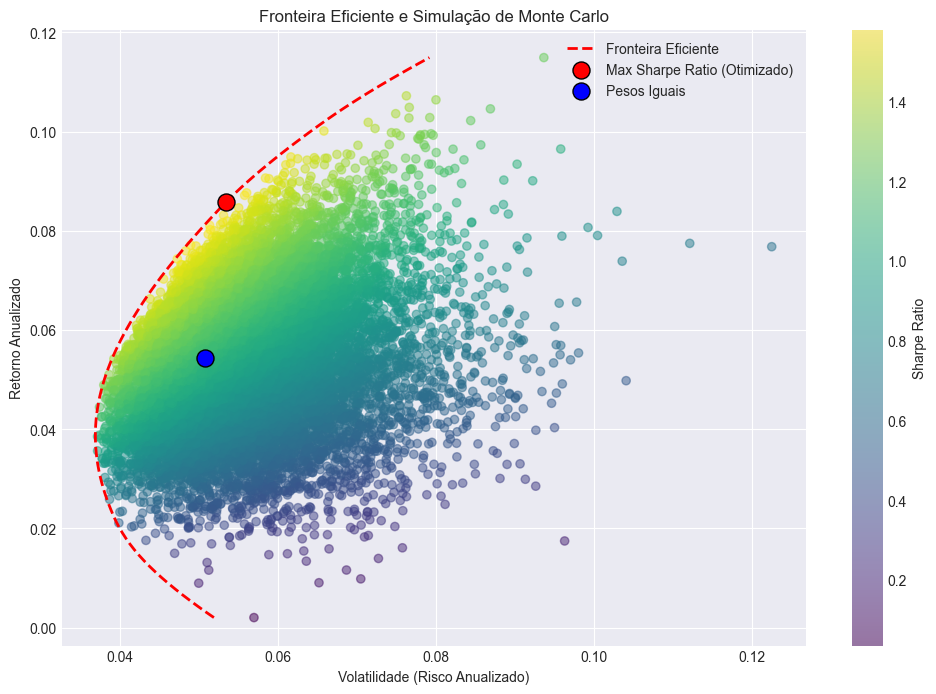

In [17]:
plt.figure(figsize=(12, 8))

# 1. Gráfico de Dispersão do Monte Carlo
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade (Risco Anualizado)')
plt.ylabel('Retorno Anualizado')
plt.title('Fronteira Eficiente e Simulação de Monte Carlo')

# 2. Fronteira Eficiente (calculada com Scipy)
plt.plot(frontier_volatility, frontier_y, 'r--', linewidth=2, label='Fronteira Eficiente')

# 3. Ponto de Maior Sharpe Ratio (Otimizado)
plt.scatter(max_sr_vol_opt, max_sr_ret_opt, c='red', s=150, edgecolors='black', label='Max Sharpe Ratio (Otimizado)', zorder=5)

# 4. Ponto de Pesos Iguais
plt.scatter(eq_vol, eq_ret, c='blue', s=150, edgecolors='black', label='Pesos Iguais', zorder=5)

plt.legend(loc='best')
plt.show()